# Google Analytics Customer Revenue Prediction

### By Hsuan-Hao Fan

We have prepared the data, `work_data.csv`, for model training in `Data_Clean_Explore.ipynb`. Let's load prepared data first, and then split it into two parts: training set and validation set.

In [2]:
# numpy
import numpy as np
print('numpy: {}'.format(np.__version__) )
import os
# pandas
import pandas as pd
print('pandas: {}'.format(pd.__version__) )
# scikit-learn
import sklearn
print('sklearn: {}'.format(sklearn.__version__))
from sklearn.model_selection import train_test_split
#from preprocess import read_data, json_read

from datetime import datetime # To access datetime

import warnings                # To ignore the warning
warnings.filterwarnings("ignore")

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
print('matplotlib: {}'.format(matplotlib.__version__))
print('seaborn: {}'.format(sns.__version__))

# statsmodels
import statsmodels
print('statsmodels: {}'.format(statsmodels.__version__))

numpy: 1.13.3
pandas: 0.21.0
sklearn: 0.19.1
matplotlib: 2.1.0
seaborn: 0.8.0
statsmodels: 0.8.0


# 1. Load Data

In [3]:
df = pd.read_csv(project.get_file('work_data.csv'))
df.head()

,date,fullVisitorId,hits,pageviews,revenue,Buy,isMobile,weekend,Referral,Americas,US
0,2016-09-02,1131660440785968503,1,1,0,0,0,0,0,0,0
1,2016-09-02,377306020877927890,1,1,0,0,0,0,0,0,0
2,2016-09-02,3895546263509774583,1,1,0,0,0,0,0,0,0
3,2016-09-02,4763447161404445595,1,1,0,0,0,0,0,0,0
4,2016-09-02,27294437909732085,1,1,0,0,1,0,0,0,0


## Data Fields

- **date** - The date on which the user visited the Store.
- **fullVisitorId**- A unique identifier for each user of the Google Merchandise Store.
- **hits** - This row and nested fields are populated for any and all types of hits. Provides a record of all page visits. 
- **pageviews** - number of pages viewed by customers per visit. 
- **revenue** - Target values, the transaction revenue per each visit
- **Buy** - Whether the customers visit GStore purchase or not ( 0: not purchasing; 1: purchasing)
- **IsMobile** - Whether customers use mobile devices to access GStore (0: not using mobile device; 1: using mobile device)
- **weekend** - Whether customers visit GStore during the weekend (0: visit in weekdays; 1: visit in weekend)
- **Referral** - Whether customers visit the store via Referral channel or not
- **Americas** - Whether customers live in Americas continent or not
- **US** - Whether customers are from United States in Americas continent.

In [4]:
# Check data types of field values
df.dtypes

date             object
fullVisitorId    object
hits              int64
pageviews         int64
revenue           int64
Buy               int64
isMobile          int64
weekend           int64
Referral          int64
Americas          int64
US                int64
dtype: object

Note that values in `date` column are in string format so we have to convert it to datetime.

In [5]:
df['date'] = pd.to_datetime(df['date'])

In [6]:
print('The data type of values in date column is {0}.'.format(df['date'].dtypes))

The data type of values in date column is datetime64[ns].


# 2. Model Construction

We will construct **training model in two steps**. First, **we create a classifier to classify whether customers will buy products or not per visit in GStore**. For those who won't purcase products in store, the transaction revenue is 0 for sure. Hence, our first step is to classify customers whether purchase or not per visit. Then for those who purchase products, **we use statistical models for time series to predict the transaction revenue per visit**. Note that we have examined that the transaction revenue per visit only depends on `date`.  

## 2.1 Classification

First of all, we classify whether customers visit store will buy products or not so the target value is `Buy` feature. 

In [7]:
df['Buy'].value_counts()

0    892138
1     11515
Name: Buy, dtype: int64

As we can see in above classes counts, our **dataset is highly imbalanced**! `Buy`:`Not Buy` $\approx$ 9:1. Also, it implies that many customers visit GStore without purchasing any products. In order to deal with imbalanced data, we adopt over-sampling from minority class, say `Buy = 1`, so we get a more balanced dataset.

### 1. First, we separate observations from each class into different DataFrames.

In [8]:
# Separate majority and minority classes
df_majority = df[df.Buy==0]
df_minority = df[df.Buy==1]

### 2. Second, we split majority and minority classes into training and validation sets with ratio 80 to 20.

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
# Split the train and the validation set for the fitting
df_major_train, df_major_val = train_test_split(df_majority, test_size = 0.25, random_state=50)
df_minor_train, df_minor_val = train_test_split(df_minority, test_size = 0.25, random_state=51)

### 3. Third, we resample the minority class with replacement, setting the number of samples to match that of the majority class in training set

We also down-sample the majority class without replacement to match that of the minority class in validation set.

In [11]:
n_samples = len(df_major_train)
m_samples = len(df_minor_val)

In [12]:
print('Number of samples in majority class of training set = {0}'.format(n_samples))
print('Number of samples in minority class of validation set = {0}'.format(m_samples))

Number of samples in majority class of training set = 669103
Number of samples in minority class of validation set = 2879


In [13]:
# Import the resampling module from Scikit-Learn
from sklearn.utils import resample

In [14]:
# Upsample minority class in training set
df_minor_train_upsampled = resample(df_minor_train,
                                   replace=True,
                                   n_samples=n_samples,
                                   random_state=100)      

# Down-sample majority class in validation set
df_major_val_downsampled = resample(df_major_val,
                                   replace=False,
                                   n_samples=m_samples,
                                   random_state=100)   

### 4. Finally, we combine the up-sampled minority class DataFrame with the original majority class DataFrame in training set

Similarly, we combine the down-sampled majority class DataFrame with the original minority class DataFrame in validation set.

In [15]:
# Combine up-sampled minority class and original majority class in training set
df_train = pd.concat([df_major_train, df_minor_train_upsampled])
del df_major_train, df_minor_train_upsampled

In [16]:
# Combine down-sampled majority class with original minor class to obtain validation set
df_val = pd.concat([df_major_val_downsampled, df_minor_val])
del df_major_val_downsampled, df_minor_val

In [17]:
df_val.head()

,date,fullVisitorId,hits,pageviews,revenue,Buy,isMobile,weekend,Referral,Americas,US
255073,2016-08-13,2735533350507336474,1,1,0,0,0,1,0,0,0
445120,2016-09-03,2575912875979409241,3,2,0,0,0,1,0,0,0
232459,2016-10-20,2034050009312896310,1,1,0,0,0,0,0,0,0
135165,2017-01-15,7651656761158865356,1,1,0,0,0,1,1,0,0
189358,2016-09-01,9129734825372279637,1,1,0,0,1,0,0,1,1


In [18]:
df_val.Buy.value_counts()

1    2879
0    2879
Name: Buy, dtype: int64

In [19]:
# Display new class counts
df_train.Buy.value_counts()

1    669103
0    669103
Name: Buy, dtype: int64

### 5. Use Tree-Based Algorithm

Decision trees often perform well on imbalanced dataset due to their hierachical structure. Since individual trees are prone to overfitting, here we apply **Random Forest** to fix it.

In [20]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

In [21]:
# Separate input features (X) and target value (y) for training set
y_train = df_train.Buy
X_train = df_train.drop(['date', 'fullVisitorId', 'Buy',  'revenue'], axis=1)

In [22]:
X_train.head()

,hits,pageviews,isMobile,weekend,Referral,Americas,US
19913,1,1,1,0,0,1,1
15972,1,1,0,0,0,0,0
300815,20,15,0,0,1,1,1
887602,6,4,0,0,1,1,1
691738,1,1,0,0,0,0,0


In [23]:
# Separate input features (X) and target value (y) for validation set
y_val = df_val.Buy
X_val = df_val.drop(['date', 'fullVisitorId', 'Buy',  'revenue'], axis=1)

In [24]:
# Train model
clf_rf = RandomForestClassifier(random_state=0)
clf_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [25]:
# Predict on training set
pred_y_train = clf_rf.predict(X_train)

# Predict on validation set
pred_y_val = clf_rf.predict(X_val)

In [26]:
# View a list of the features and their importance scores

list(zip(X_train, clf_rf.feature_importances_))

[('hits', 0.48879725348659375),
 ('pageviews', 0.32851432098802047),
 ('isMobile', 0.0086083490947754769),
 ('weekend', 0.0014296020197403089),
 ('Referral', 0.0074665077311028977),
 ('Americas', 0.080567801941834327),
 ('US', 0.084616164737932709)]

### 6. Evaluate model

We implement **confusion matrix**, **precision, and **recall** metrics. **Note that in order to evaluate performance properly, it is better to make sure that either class in validation set is balanced**. For example, if negative class has much larger number of samples than positive class like what we have now, then FP is probably much larger than FN, or $FP \gg FN$. That means one will have very small precision value since

$$ precision = \frac{TP}{TP + FP}; \qquad recall = \frac{TP}{TP+FN}.$$

If we use imbalanced data to evaluate our model, then it will lead to very small precision value. In this situation, it is very hard to judge whether the low precision value is due to model performance or due to imbalanced data. Hence, one should block the later factor to evaluate model properly.

In [27]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

### Confusion Matrix:

In [28]:
print('Confusion matrix for training set is \n {0}.'.format(confusion_matrix(y_train, pred_y_train)))
print('Confusion matrix for validation accuracy is \n {0}.'.format(confusion_matrix(y_val, pred_y_val)))

Confusion matrix for training set is 
 [[636834  32269]
 [  6769 662334]].
Confusion matrix for validation accuracy is 
 [[2732  147]
 [ 503 2376]].


In [29]:
# Is our model still predicting just one class?
print( np.unique( pred_y_train ) )
print( np.unique( pred_y_val ) )

[0 1]
[0 1]


### Precision and Recall:

In [30]:
# Calculate precision score
print('Precision for training set is {}.'.format(precision_score(y_train, pred_y_train)))
print('Precision for validation set is {}.'.format(precision_score(y_val, pred_y_val)))

Precision for training set is 0.9535432470058436.
Precision for validation set is 0.9417360285374554.


In [31]:
# Calculate recall score
print('Recall for training set is {}.'.format(recall_score(y_train, pred_y_train)))
print('Recall for validation set is {}.'.format(recall_score(y_val, pred_y_val)))

Recall for training set is 0.9898834708557577.
Recall for validation set is 0.8252865578325808.


From above results, we can see that the current model is overfitting. From important score, we can see that `weekend`, `Referral`, `isMobile` features are not that important compared to other selected features so let's drop them in our model, and repeat above procedure again.

### 7. Drop weekend, Referral, and isMobile features

In [32]:
# Separate input features (X) and target value (y) for training set
y_train_1 = df_train.Buy
X_train_1 = df_train.drop(['date', 'fullVisitorId', 'Buy',  'revenue', 'weekend', 'Referral', 'isMobile'], axis=1)

In [33]:
X_train_1.head()

,hits,pageviews,Americas,US
19913,1,1,1,1
15972,1,1,0,0
300815,20,15,1,1
887602,6,4,1,1
691738,1,1,0,0


In [34]:
# Separate input features (X) and target value (y) for validation set
y_val_1 = df_val.Buy
X_val_1 = df_val.drop(['date', 'fullVisitorId', 'Buy',  'revenue', 'weekend', 'Referral', 'isMobile'], axis=1)

In [35]:
# Train model
clf_rf1 = RandomForestClassifier(random_state=1)
clf_rf1.fit(X_train_1, y_train_1)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [36]:
# Predict on training set
pred_y_train_1 = clf_rf1.predict(X_train_1)

# Predict on validation set
pred_y_val_1 = clf_rf1.predict(X_val_1)

In [37]:
# View a list of the features and their importance scores

list(zip(X_train_1, clf_rf1.feature_importances_))

[('hits', 0.29291224520563208),
 ('pageviews', 0.67902630132170649),
 ('Americas', 0.015532863136854175),
 ('US', 0.012528590335807286)]

In [38]:
# Calculate confusion matrix
print('Confusion matrix for training set is \n {0}.'.format(confusion_matrix(y_train_1, pred_y_train_1)))
print('Confusion matrix for validation accuracy is \n {0}.'.format(confusion_matrix(y_val_1, pred_y_val_1)))

Confusion matrix for training set is 
 [[629933  39170]
 [  9718 659385]].
Confusion matrix for validation accuracy is 
 [[2702  177]
 [ 260 2619]].


In [39]:
# Calculate precision score
print('Precision for training set is {}.'.format(precision_score(y_train_1, pred_y_train_1)))
print('Precision for validation set is {}.'.format(precision_score(y_val_1, pred_y_val_1)))

Precision for training set is 0.9439271066701977.
Precision for validation set is 0.9366952789699571.


In [40]:
# Calculate recall score
print('Recall for training set is {}.'.format(recall_score(y_train_1, pred_y_train_1)))
print('Recall for validation set is {}.'.format(recall_score(y_val_1, pred_y_val_1)))

Recall for training set is 0.9854760776741398.
Recall for validation set is 0.9096908648836401.


As we can see above, we obtained better recall for validation set and less overfitting. 

In [41]:
# delete temporary DataFrames
del X_train, X_val, y_train, y_val


## 2.2 Predict Transaction Revenue per Visit

After classification, we can predict whether customers will purchase products or not. **For those who will not buy things in GStore, we can set transaction revenue per visit as 0**. For those who purchase products, **we use statistical models for time series to predict the transaction revenue per visit**.

In [42]:
df_buy = df[df['Buy']==1]
df_buy.head()

,date,fullVisitorId,hits,pageviews,revenue,Buy,isMobile,weekend,Referral,Americas,US
752,2016-09-02,6194193421514403509,11,11,37860000,1,0,0,0,1,1
753,2016-09-02,5327166854580374902,11,10,306670000,1,0,0,0,1,1
799,2016-09-02,8885051388942907862,13,11,68030000,1,0,0,1,1,1
802,2016-09-02,0185467632009737931,13,12,26250000,1,0,0,1,1,1
859,2016-09-02,3244885836845029978,17,14,574150000,1,0,0,1,1,1


In [43]:
df_buy.dtypes

date             datetime64[ns]
fullVisitorId            object
hits                      int64
pageviews                 int64
revenue                   int64
Buy                       int64
isMobile                  int64
weekend                   int64
Referral                  int64
Americas                  int64
US                        int64
dtype: object

In [44]:
df_time = df_buy[['date', 'revenue']]

In [45]:
del df_buy

In [46]:
df_time.head()

,date,revenue
752,2016-09-02,37860000
753,2016-09-02,306670000
799,2016-09-02,68030000
802,2016-09-02,26250000
859,2016-09-02,574150000


In [47]:
# Calculate average transaction revenue per visit
Time_series = df_time.groupby('date').mean()
Time_series.head()

,revenue
date,
2016-08-01,1.798841e+08
2016-08-02,8.007000e+07
2016-08-04,6.958176e+07
2016-08-05,1.364454e+08
2016-08-06,1.891040e+08


In [48]:
del df_time

In [49]:
# Reset the index
Time_series.reset_index()

,date,revenue
0,2016-08-01,1.798841e+08
1,2016-08-02,8.007000e+07
2,2016-08-04,6.958176e+07
3,2016-08-05,1.364454e+08
4,2016-08-06,1.891040e+08
5,2016-08-07,1.506706e+08
6,2016-08-08,1.551121e+08
7,2016-08-09,1.332476e+08
8,2016-08-10,9.313500e+07
9,2016-08-11,1.650471e+08


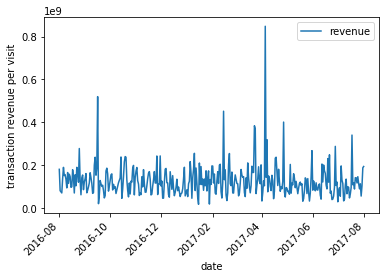

In [50]:
# Plot the time series
Time_series.plot(rot=45)
plt.ylabel('transaction revenue per visit')
plt.show()

### 1. Box-Jenkins Analysis

We use Box-Jenkins Analysis to help us construct statistical model for time series.

First, let's look at **Autocorrelation Function (ACF)** to help observe linear relationships between lagged values of a time series. 

In [51]:
from statsmodels.graphics.tsaplots import plot_acf

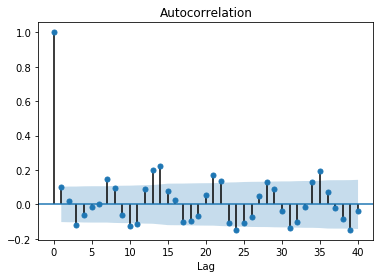

In [52]:
# Plot ACF 
plot_acf(Time_series['revenue'], lags=40)
plt.xlabel('Lag')
plt.show()

Note that the light blue shaded area is confidence intervals. By default, this is set to a 95% confidence interval. From above ACF plot, there's no slowly decay as lags increase. This implies that there's no trend. 

Next, we consider **partial autocorrelation function (PACF)**.

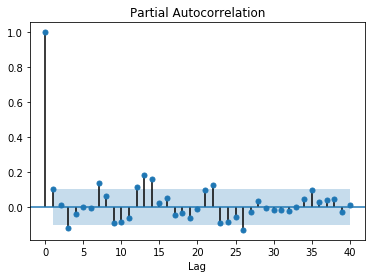

In [53]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(Time_series['revenue'], lags=40)
plt.xlabel('Lag')
plt.show()

### Differencing

Next, we apply differencing $Y_t = X_t - X_{t-1}$, where $t$ is date, 1 is the seasonal period, and $X$ denotes the original data. This differencing is called a **lag-1 difference**.

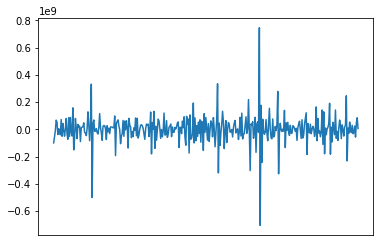

In [54]:
diff1 = Time_series.diff(periods=1)
diff1.dropna(inplace=True)
plt.plot(diff1)
plt.xticks([])
plt.show()

After applying differencing, the time series looks approximately stationary (at least the mean and variance are more-or-less constant).

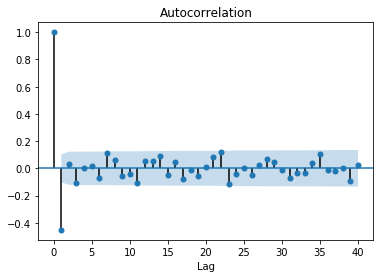

In [55]:
# Plot ACF 
plot_acf(diff1, lags=40)
plt.xlabel('Lag')
plt.show()

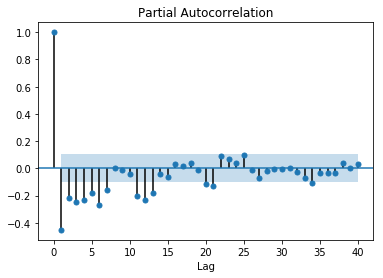

In [56]:
# Plot PACF 
plot_pacf(diff1, lags=40)
plt.xlabel('Lag')
plt.show()

From above ACF and PACF plots, they indicate the time series $Y_t$ suitable for **Moving Average Time Series Model with 1 moving-average term**, or `MA(1)`:

$$ Y_t = \beta_1 E_{t-1} + E_t$$

where $E_t$ is an error term at time instance $t$. In `MA(1)`, the current observation depends only to the error in the previous time instance and the current error.

Since $Y_t = X_t - X_{t-1}$, the above equation leads to

$$ X_t - X_{t-1} = \beta_1 E_{t-1} + E_t \Rightarrow X_t = X_{t-1} + \beta_1 E_{t-1} + E_t $$

Hence, we use **ARMA model (mix AR and MA models)**, where `AR` means **A**uto**r**egressive Time Series Model. That is, we implement `ARMA(a,m)` in `statsmodels` library with $a = 1$ and $m=1$.

### 2. Splitting the data into training and validation parts

We will divide our data in train and vaidation sets, and make a model on the train set and predict on the validation set to check the accuracy of our predictions.

In [57]:
Train = Time_series.ix['2016-08-04':'2017-04-30']

# Select the last 3 months for the validation data
Valid = Time_series.ix['2017-05-01':'2017-08-01']

In [58]:
Train.index

DatetimeIndex(['2016-08-04', '2016-08-05', '2016-08-06', '2016-08-07',
               '2016-08-08', '2016-08-09', '2016-08-10', '2016-08-11',
               '2016-08-12', '2016-08-13',
               ...
               '2017-04-21', '2017-04-22', '2017-04-23', '2017-04-24',
               '2017-04-25', '2017-04-26', '2017-04-27', '2017-04-28',
               '2017-04-29', '2017-04-30'],
              dtype='datetime64[ns]', name='date', length=270, freq=None)

In [59]:
Valid.index

DatetimeIndex(['2017-05-01', '2017-05-02', '2017-05-03', '2017-05-04',
               '2017-05-05', '2017-05-06', '2017-05-07', '2017-05-08',
               '2017-05-09', '2017-05-10', '2017-05-11', '2017-05-12',
               '2017-05-13', '2017-05-14', '2017-05-15', '2017-05-16',
               '2017-05-17', '2017-05-18', '2017-05-19', '2017-05-20',
               '2017-05-21', '2017-05-22', '2017-05-23', '2017-05-24',
               '2017-05-25', '2017-05-26', '2017-05-27', '2017-05-28',
               '2017-05-29', '2017-05-30', '2017-05-31', '2017-06-01',
               '2017-06-02', '2017-06-03', '2017-06-04', '2017-06-05',
               '2017-06-06', '2017-06-07', '2017-06-08', '2017-06-09',
               '2017-06-10', '2017-06-11', '2017-06-12', '2017-06-13',
               '2017-06-14', '2017-06-15', '2017-06-16', '2017-06-17',
               '2017-06-18', '2017-06-19', '2017-06-20', '2017-06-21',
               '2017-06-22', '2017-06-23', '2017-06-24', '2017-06-25',
      

In [60]:
Train.dtypes

revenue    float64
dtype: object

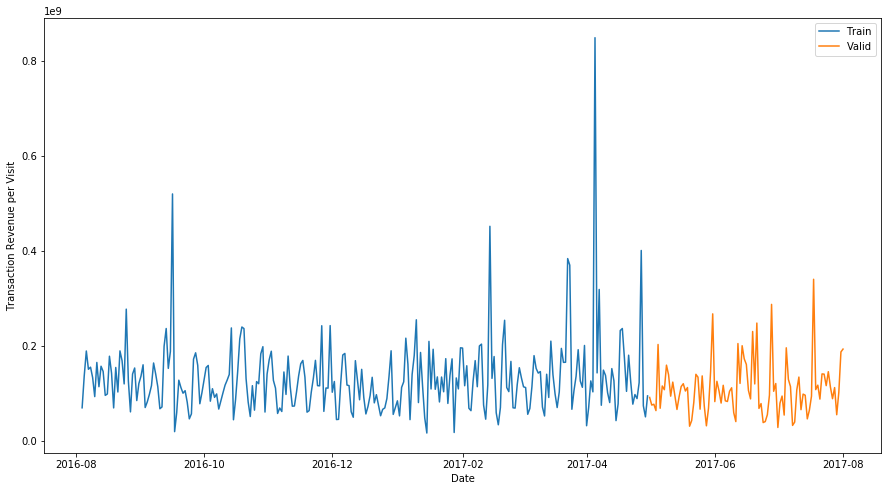

In [61]:
# Plot transaction revenue per visit vs. date
plt.figure(figsize=(15,8))
plt.plot(Train.index, Train['revenue'], Valid.index, Valid['revenue'])
plt.xlabel("Date")
plt.ylabel("Transaction Revenue per Visit")
plt.legend(('Train', 'Valid'), loc='best')
plt.show()

Here, the blue part represents the training data and the orange part represents the validation data. We will predict the transaction revenue per visit for the validation part and then visualize how accurate our predictions are. Finally we will make predictions for the test dataset for those who will purchase products in GStore.

### 3. Autoregressive Moving Average ARMA(a,m) Model

In [62]:
from statsmodels.tsa.arima_model import ARMA

In [63]:
# Rescale the values in revenue column
Train['revenue'] *= 10**(-8)

In [64]:
Valid['revenue'] *= 10**(-8)

In [65]:
Train.head()

,revenue
date,
2016-08-04,0.695818
2016-08-05,1.364454
2016-08-06,1.891040
2016-08-07,1.506706
2016-08-08,1.551121


In [66]:
# Convert date to timestamps
Train.index = pd.to_datetime(Train.index)

In [67]:
Valid.index = pd.to_datetime(Valid.index)

In [68]:
# fit model
model = ARMA(Train, order=(1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                revenue   No. Observations:                  270
Model:                     ARMA(1, 1)   Log Likelihood                -320.386
Method:                       css-mle   S.D. of innovations              0.793
Date:                Fri, 30 Nov 2018   AIC                            648.772
Time:                        18:23:40   BIC                            663.166
Sample:                    08-04-2016   HQIC                           654.552
                         - 04-30-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.3051      0.053     24.664      0.000       1.201       1.409
ar.L1.revenue     0.0822      0.361      0.228      0.820      -0.625       0.790
ma.L1.revenue     0.0071      0.358     

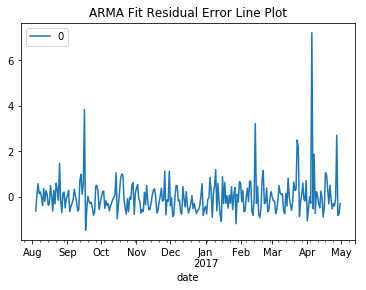

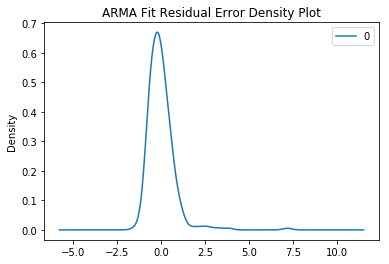

                0
count  270.000000
mean     0.000200
std      0.794156
min     -1.458306
25%     -0.494101
50%     -0.122179
75%      0.286571
max      7.203895


In [69]:
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.title('ARMA Fit Residual Error Line Plot')
plt.show()
residuals.plot(kind='kde')
plt.title('ARMA Fit Residual Error Density Plot')
plt.show()
print(residuals.describe())

The distribution of the residual errors is displayed at the bottom. The results show that the mean in the residuals is close to zero so there is no bias in the prediction. 

### Evaluation

Now that the model has been fitted to the training data, we are ready to forecast into the future.

In [70]:
Valid.index

DatetimeIndex(['2017-05-01', '2017-05-02', '2017-05-03', '2017-05-04',
               '2017-05-05', '2017-05-06', '2017-05-07', '2017-05-08',
               '2017-05-09', '2017-05-10', '2017-05-11', '2017-05-12',
               '2017-05-13', '2017-05-14', '2017-05-15', '2017-05-16',
               '2017-05-17', '2017-05-18', '2017-05-19', '2017-05-20',
               '2017-05-21', '2017-05-22', '2017-05-23', '2017-05-24',
               '2017-05-25', '2017-05-26', '2017-05-27', '2017-05-28',
               '2017-05-29', '2017-05-30', '2017-05-31', '2017-06-01',
               '2017-06-02', '2017-06-03', '2017-06-04', '2017-06-05',
               '2017-06-06', '2017-06-07', '2017-06-08', '2017-06-09',
               '2017-06-10', '2017-06-11', '2017-06-12', '2017-06-13',
               '2017-06-14', '2017-06-15', '2017-06-16', '2017-06-17',
               '2017-06-18', '2017-06-19', '2017-06-20', '2017-06-21',
               '2017-06-22', '2017-06-23', '2017-06-24', '2017-06-25',
      

In [71]:
# prediction for validation set
model_fit.forecast(steps=100)[0]

array([ 1.27361711,  1.30252853,  1.30490389,  1.30509905,  1.30511509,
        1.3051164 ,  1.30511651,  1.30511652,  1.30511652,  1.30511652,
        1.30511652,  1.30511652,  1.30511652,  1.30511652,  1.30511652,
        1.30511652,  1.30511652,  1.30511652,  1.30511652,  1.30511652,
        1.30511652,  1.30511652,  1.30511652,  1.30511652,  1.30511652,
        1.30511652,  1.30511652,  1.30511652,  1.30511652,  1.30511652,
        1.30511652,  1.30511652,  1.30511652,  1.30511652,  1.30511652,
        1.30511652,  1.30511652,  1.30511652,  1.30511652,  1.30511652,
        1.30511652,  1.30511652,  1.30511652,  1.30511652,  1.30511652,
        1.30511652,  1.30511652,  1.30511652,  1.30511652,  1.30511652,
        1.30511652,  1.30511652,  1.30511652,  1.30511652,  1.30511652,
        1.30511652,  1.30511652,  1.30511652,  1.30511652,  1.30511652,
        1.30511652,  1.30511652,  1.30511652,  1.30511652,  1.30511652,
        1.30511652,  1.30511652,  1.30511652,  1.30511652,  1.30

**After 6 steps, the predicted values become constant. There must be something wrong about application. Need to figure out how to do prediction correctly!**